# Map inversion and event sensitivities

In this notebook we experiment with the map inversion technique, implemented as detailed in the work:

*Martin Bertz* Modern Map Methods in Particle Beam Physics Academic Press (1999) pp.102 ([pdf](https://www.bmtdynamics.org/pub/papers/AIEP108book/AIEP108book.pdf))

The technique is of interest in the context of *heyoka* as it allows to invert efficiently systems of polynomial equations, for example the Taylor maps constructed from the variational equations.

In a [previous example](./ev_sensitivity.ipynb) we toyed with the idea of computing, for a generic event, the variations of its trigger time. In this notebook we set ourself the task to compute the very same thing for a generic system and eventually build Taylor maps relating the initial conditions to the final state at the event trigger time. We will need the map inversion algorithm to achieve our goals.

This is interesting, for example, in the context of planetary landing, sphere-of-influence entry condtions, Poincare' sections etc.. as it allows to propagate efficiently uncertainties up to the event manifold, for example, using the machinery of the [moment generating functions](https://www.probabilitycourse.com/chapter6/6_1_3_moment_functions.php).

Let us get started with some necessary imports:

In [1]:
# Core imports
import heyoka as hy
import numpy as np
import matplotlib as plt
import math
from copy import deepcopy

# Plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Preamble

**How does the final state of a dynamical system vary when we perturb its initial conditions and parameters and the integration time is decided by a terminal event?**

We consider a generic set of ODEs:

$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = \mathbf f(\mathbf x) \\
\mathbf {x(0)} = \mathbf x_0
\end{array}
\right.
$$
and denote its solution as $\mathbf x(t, \mathbf x_0)$.

We now perform a numerical integration and stop at the time $T$ when some event condition $\mathbf e(\mathbf x(T, \mathbf x_0)) = \mathbf 0$ is satisfied. 

If we were to repeat the numerical integration from slightly perturbed initial conditions, the time at which the event would be triggered also will also be perturbed so that:
$$
\mathbf e\big(\mathbf x(T + \delta T, \mathbf x_0 + \delta \mathbf x_0)\big) = \mathbf 0
$$

In this notebook we will use *heyoka* to obtain polynomial expansions $\mathcal P$ of the final state and the event trigger time. That is, we seek to find:

$$
\left\{
\begin{array}{l}
\mathbf x_f = \mathcal P_{x_f}^n(\delta \mathbf x_0, \delta T)\\
\delta T = \mathcal P_T^n(\delta \mathbf x_0)
\end{array}
\right.
$$

This all may seem a bit complicated at this point, so it may help to imagine it before we start: we are building (in an automated fashion) high degree polynomials (also called Taylor maps) representing the sensitivities at the final event with respect to the initial conditions. 

We use, as an example, a particle subject to a gravity field and free falling up to when it collides with a spherical surface placed beneath it: **We want to describe the point where the particle collides with the sphere as a function of its initial state.**

Let us start to define our dynamical system $\mathbf f$:


In [2]:
# Create the symbolic variables for the state.
x, y, vx, vy = hy.make_vars("x", "y", "vx", "vy")
r = hy.sqrt(x**2 + y**2)

# The simple dynamics is described by the following:
dyn = [vx, vy, -1.0 / r**3 * x, -1.0 / r**3 * y]

# We assemble the system in the heyoka syntax
sys = []
sys.append((x, dyn[0]))
sys.append((y, dyn[1]))
sys.append((vx, dyn[2]))
sys.append((vy, dyn[3]))

and the event $\mathbf e$:

In [3]:
# Let us create the event
# Genric callback for a terminal event -> it does nothing except stopping the adaptive integrator when triggered.
def t_cb(ta, d_sgn):
    # Do stop the integration.
    return False


# Define a sphere of radius 1 (our planet :)
ev_expr = x**2 + y**2 - 1

# ... and the terminal event
t_ev = hy.t_event(
    # The event equation.
    ev_expr,
    # The callback.
    callback=t_cb,
)

We now construct a Taylor integrator with the defined event.


In [4]:
ta = hy.taylor_adaptive(sys, [0.1] * 4, compact_mode=True, t_events=[t_ev])

And test it on some nominal case

In [5]:
# Lets propagate
ic = [0.1, 2.3, 0.4, 0.1]
tof = 6.0

ta.state[:4] = ic

ta.time = 0.0
ta.reset_cooldowns()  # to be sure in case we evaluatre the cell twice in a row

t_grid_ta = np.linspace(0.0, tof)

out_ta = ta.propagate_grid(t_grid_ta)

trigger_time = ta.time
print("The event (hitting the sphere) triggers at: ", trigger_time)

The event (hitting the sphere) triggers at:  5.494381002478122


NOTE: The numerical propagation has terminated but, while the state of the *ta* object is the one at the event time trigger, the actual values contained in the array returned by *propagate_grid* miss this last point as its not on the requested grid. We thus create new variables and append there the necessary values.

In [6]:
out = np.vstack((out_ta[-1], ta.state.reshape(1, -1)))
t_grid = t_grid_ta[t_grid_ta < ta.time]
t_grid = np.hstack((t_grid, [ta.time]))

Lets have a look to the falling point:

(-1.1148950888171956,
 1.412796865161107,
 -1.166336608935997,
 2.4930687876559348)

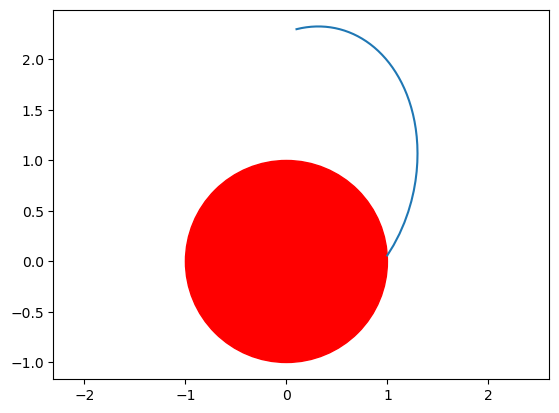

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(out[:, 0], out[:, 1])

circle = plt.Circle((0, 0), 1, color="r")
ax.add_patch(circle)
plt.axis("equal")

## Augmenting our system

Naturally, our object followed some kind of Keplerian orbit and stopped when it hit the sphere.

In order to understand where the object would hit the sphere, should we change the initial conditions, we need to transform our set of ODEs applying a few tricks. 

We started from:

$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = v_x \\
\mathbf {\dot y} = v_y \\
\mathbf {\dot v_x} = - x/r^3 \\
\mathbf {\dot v_y} = - y/r^3 \\
\end{array}
\right.
$$

and the event $e = x^2 + y^2 -1 = 0$.

and we integrated up to the event trigger time $T$. Let us now, instead, consider the ODE system:
$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = T v_x \\
\mathbf {\dot y} = T v_y \\
\mathbf {\dot v_x} = - T x/r^3 \\
\mathbf {\dot v_y} = - T y/r^3 \\
\mathbf {\dot e} = T \nabla e \cdot \mathbf f
\end{array}
\right.
$$

with the added initial condition $e(t=0) = e(x_0, y_0, v_{x_0}, v_{y_0})$. We integrate this system up to $t=1$, as we now consider the actual integration time as an ODE parameter. Note that we also added one equation which will track the event value along the dynamics.

Using this augmented system of equations we build a variational integrator so that all high orders variations, including the ones w.r.t. $T$ will be computed:


In [8]:
# Auxiliary variable for the equation tracking the event
e = hy.make_vars("e")
# We compile the event function for later use
ev_cfunc = hy.cfunc([ev_expr], vars=[x, y, vx, vy])
# To compute the auxiliary equation we need the event gradient
ev_grad = hy.diff_tensors([ev_expr], diff_args=[x, y, vx, vy], diff_order=1).gradient

# We define the augmented system
sys_aug = []
sys_aug.append((x, hy.par[0] * dyn[0]))
sys_aug.append((y, hy.par[0] * dyn[1]))
sys_aug.append((vx, hy.par[0] * dyn[2]))
sys_aug.append((vy, hy.par[0] * dyn[3]))
sys_aug.append((e, hy.par[0] * np.dot(ev_grad, dyn)))

... and compute the variational system:

In [9]:
# Create the variational ODE system (symbolic).
vsys = hy.var_ode_sys(sys_aug, [x, y, vx, vy, e, hy.par[0]], order=4)

... and build the variational integrator:

In [10]:
# Construct the Taylor integrator containing also variational equations (llvm)
ta_var = hy.taylor_adaptive(vsys, [0.1] * 5, compact_mode=True)
# We store the initial conditions on the variational equations for future resets
ic_var = ta_var.state[5:]
print("Variational equations built, variations considered are: ", ta_var.vargs)

Variational equations built, variations considered are:  [x, y, vx, vy, e, p0]


We thus may now integrate this system up to a unitary time ($T$ actually now represents the integration time as a parameter)

In [11]:
# Lets propagate
ic_aug = ic + [ev_cfunc(ic)[0]]

ta_var.state[:5] = ic_aug
ta_var.state[5:] = ic_var
ta_var.pars[:] = trigger_time

ta_var.time = 0.0

t_grid_ta_var = np.linspace(0.0, 1.0)

out_ta = ta_var.propagate_grid(t_grid_ta_var)

Just to verify, we look at the value of $e$ at the end of our integration and check that is zero indeed:

In [12]:
print("The event state variable e value at the end is: ", ta_var.state[4])

The event state variable e value at the end is:  -8.673833409892439e-16


Here is perhaps a good place to stop for a second and ponder on what we have computed. Looking into how we defined and built the variational equations, it should be easy to see that calls to the method *eval_taylor_map* will use the following representations:


$$
\left\{
\begin{array}{l}
\delta x_f = \mathcal P_{x_f}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta y_f = \mathcal P_{y_f}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta v_{x_f} = \mathcal P_{v_{x_f}}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta v_{y_f} = \mathcal P_{v_{y_f}}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta T)\\
\delta e_f = \mathcal P_{e_f}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta T)
\end{array}
\right.
$$

where $\mathcal P^n_\circ$ are multivariate polynomials of order $n$. Note that the variation w.r.t. the initial condition $e_0$ only appears in the last equation as that state variable does not affect any of the other equations (the ones referring to the original, non augmented, dynamics.)



Comparing this to what we wanted to compute we can see that we are getting very close, except the last equation, where we would rather have something
 like $\delta T = \mathcal P_T^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta e_f)$ to then set $\delta e_f=0$ and $\delta e_0 = e(\mathbf x_0+\delta \mathbf x_0) - e(\mathbf x_0)$.
 
To obtain this expression we need to invert the last equation!

## The map inversion algorithm

We need to write a few helper function as to be able to perform the map inversion in **heyoka.py**. Fistly we must be able to extract the symbolic epressions of the polynomials $\mathcal P^n_\circ$ from the various states of the variational equations. 

This is done via this simple helper, that returns already the quantities in the needed form:

In [13]:
def multi_factorial(mindex: list[int]):
    # Using math.prod for exact integer factorials
    return math.prod([math.factorial(i) for i in mindex])

In [14]:
def extract_taylor_map(ta_var, state_vars, vargs, separate_linear_part: bool = True):
    """Extracts from the variational equations the Taylor maps (linear and non-
    linear parts separated if needed) of states_id w.r.t. the vargs.

    Parameters
    ==========
        - ta_var: hy.core.taylor_adaptive_dbl
            The variational ODE system from Heyoka.
        - states_vars: list[hy.expression]
            The state vector variables for which we want to extract the Taylor
            map. These are Heyoka symbols.
        - vargs: list[hy.expression]
            The variational arguments that will be inputs of the map. These are
            Heyoka symbols.
        - separate_linear_part: bool
            If True, returns the linear part and nonlinear part of the Taylor
            map separately, otherwise returns it in one list. See below for
            a description of the output.

    Returns
    =======
        - matrix: np.array
            The linear part of the map, as a numpy matrix. Returned only if
            separate_linear_part is True.
        - N: list[hy.expression]
            The nonlinear part of the map, as a list of symbolic expressions.
        - vargs_d0: list[hy.expression]
            The symbols representing perturbations of vargs at t_0. If vargs
            is, for example, [x, y, z], this will be [dx_0, dy_0, dz_0, ...].
    """
    vargs_d0 = [hy.make_vars(f"d{varg}_0") for varg in ta_var.vargs]
    all_state_vars = [ta_var.sys[i][0] for i in range(ta_var.n_orig_sv)]
    all_vargs = ta_var.vargs

    N = [hy.expression(0)] * len(state_vars)
    matrix = np.zeros((len(state_vars), len(vargs)))

    # We loop over all partial derivatives in the system
    # By skipping the first n terms, we effectively skip the 0th order
    # derivatives, which means the result is a Taylor polynomial in dx, dy, ...
    # rather than in x, y, ...
    for i in range(ta_var.n_orig_sv, len(ta_var.sys)):
        mindex = ta_var.get_mindex(i)
        state_index = mindex[0]
        state_var = all_state_vars[state_index]
        mindex = mindex[1:]

        # If not, we only consider the term if it corresponds to a selected state
        if state_var not in state_vars:
            continue

        # .. and contains only the selected vargs
        skip = False
        for varg_index, varg_order in enumerate(mindex):
            varg = all_vargs[varg_index]
            if varg not in vargs and varg_order > 0:
                skip = True
                break

        if skip:
            continue

        # At this point we know we need to add this term to the corresponding map
        monomial = 1.0
        for varg in vargs:
            varg_index = all_vargs.index(varg)
            monomial *= vargs_d0[varg_index] ** mindex[varg_index]

        value = ta_var.state[i] / multi_factorial(mindex)

        if separate_linear_part and sum(mindex) == 1:
            varg_index = mindex.index(1)
            varg = ta_var.vargs[varg_index]
            matrix[state_vars.index(state_var), vargs.index(varg)] = value
        else:
            N[state_vars.index(state_var)] += value * monomial

    if separate_linear_part:
        return matrix, N, vargs_d0
    else:
        return N, vargs_d0

We will also need to compose maps (the operator $\mathcal M_1\circ \mathcal M_2$ in the notation used by Berz in his book), each is a simple substituion, sum them and subtract them. For the purpose of this notebook a map $\mathcal M$ is an array of $n$ polynomials each with $m$ input variables. The Map is square if $n=m$. The following functions are helpers doing just that:

In [15]:
def map_composition(A, B, symbols):
    tmp = deepcopy(A)
    for j in range(len(symbols)):
        tmp = hy.subs(tmp, {symbols[j]: B[j]})
    return tmp


def map_difference(A, B):
    C = []
    for i in range(len(A)):
        C.append(A[i] - B[i])
    return C

Finally we can write the algorithm of map inversion:

In [26]:
def invert_taylor_map(
    matrix: np.array,
    N: list[hy.expression],
    order: int,
    forward_inputs: list[hy.expression],
    forward_outputs: list[hy.expression],
) -> list[hy.expression]:
    """This inverts a square Taylor map. We refer to the map given as parameter
    of this function as the forward map, and the output of this function as the
    inverse map.

    Parameters
    ==========
        - matrix: np.ndarray
            The numerical linear part of the forward map
        - N: list[hy.expression]
            The symbolic nonlinear part of the forward map
        - forward_inputs: list[hy.expression]
            The list of input variables the forward map. This will be the
            outputs of the inverse map.
        - forward_outputs: list[hy.expression]
            The list of output variables of the forward map. This will be the
            input of the inverse map.
        - order: int
            The order of truncation of the forward map

    Returns
    ========
        - M_inv: list[hy.expression]
            A symbolic expression of the inverse map.
    """

    if abs(np.linalg.det(matrix)) < 1e-10:
        raise ValueError("The linear map is not invertible")
    matrix_inv = np.linalg.inv(matrix)

    # Dummy symbols used to avoid issues during map inversion
    dx = hy.make_vars(*["dx" + str(i) for i in range(len(N))])
    # If the map is length 1, heyoka.make_vars returns a value instead of a list
    # Let us convert is to a list in all cases
    if not isinstance(dx, list):
        dx = [dx]

    # The identity map with dummy symbols dx0, dx1...
    Id_dx = dx

    # Symbolic inverse of `matrix` where the symbols are dx0, dx1, ...
    M_inv_dx = list(np.matmul(matrix_inv, dx))

    # This is the same as M_inv_dx but with true symbols
    # This one is not modified during the iterations
    M_inv_inputs = map_composition(M_inv_dx, forward_inputs, dx)

    # We iterate n times
    for i in range(order - 1):
        M_inv_dx = map_composition(
            M_inv_inputs,
            map_difference(Id_dx, map_composition(N, M_inv_dx, forward_inputs)),
            forward_inputs,
        )

    # Substitute the true symbols in place of the dx
    M_inv = map_composition(M_inv_dx, forward_outputs, dx)

    return hy.cfunc(M_inv, vars=forward_outputs)

## Using the map inversion 
We now use the function **invert_taylor_map** defined above to compute:

$$
\delta T = \mathcal P_T^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta e_f)
$$

inverting the expression available from the variational integrator:

$$
\delta e_f = \mathcal P_{e_f}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta T)
$$

To do that, first we complete the forward map to make it square (same number of outputs as inputs). The other
components are identity functions of the inputs:

$$
\mathcal M(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta T)=\begin{bmatrix}
    \delta x_0 \\
    \delta y_0 \\
    \delta v_{x_0} \\
    \delta v_{y_0} \\
    \delta e_0 \\
    \mathcal P_{e_f}^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta T)
\end{bmatrix}
$$

Then the inverse is a map of the form

$$
\mathcal M^{-1}(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta e_f)=\begin{bmatrix}
    \delta x_0 \\
    \delta y_0 \\
    \delta v_{x_0} \\
    \delta v_{y_0} \\
    \delta e_0 \\
    \mathcal P_T^n(\delta x_0, \delta y_0, \delta v_{x_0}, \delta v_{y_0}, \delta e_0, \delta e_f)
\end{bmatrix}
$$

The function that gives $\delta T$ for given initial variations and $\delta e_f$ is thus the last component of the inverted map. Note that there is nothing forcing us to put $\mathcal P_{e_f}^n$ at the end of the forward map, we could as well have put it at the beginning. This just changes the order of the inputs of the inverse map. 

In [27]:
# First we extract te symbolic map of the event equation w.r.t. the variations of all the six states + param (dT is hy.par[0])
matrix_, N_, vargs_d0 = extract_taylor_map(ta_var, [e], [x, y, vx, vy, e, hy.par[0]])

# Extract the symbols correspondings to deltas in vargs
dx_0, dy_0, dvx_0, dvy_0, de_0, dT = vargs_d0
# Create a symbol for the output of the forward map
de_f = hy.make_vars("de_f")

# Then we augment it wth identities as to obtain a squared map
N = [hy.expression(0)] * 5 + [N_[0]]
matrix = np.eye(6)
matrix[-1, :] = matrix_

# And invert it
invmap = invert_taylor_map(
    matrix,
    N,
    ta_var.vorder,
    forward_inputs=[dx_0, dy_0, dvx_0, dvy_0, de_0, dT],
    forward_outputs=[dx_0, dy_0, dvx_0, dvy_0, de_0, de_f],
)
invmap

C++ datatype: double
Variables: [dx_0, dy_0, dvx_0, dvy_0, de_0, de_f]
Output #0: (((dx_0 - (7.9221665789629896e-16 * dvx_0)) - (4.0262191175573771e-17 * de_0)) + (5.2512346174888256e-17 * (de_f - ((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((1.7801924144899577 * (((dx_0 - (7.9221665789629896e-16 * dvx_0)) - (4.0262191175573771e-17 * de_0)) + (5.2512346174888256e-17 * (de_f - ((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((1.7801924144899577 * (((dx_0 - (7.9221665789629896e-16 * dvx_0)) - (4.0262191175573771e-17 * de_0)) + (5.2512346174888256e-17 * (de_f - ((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((1.7801924144899577 * (((dx_0 - (7.9221665789629896e-16 * dvx_0)) - (4.0262191175573771e-17 * de_0)) + (5.2512346174888256e-17 * de_f))**2.0000000000000000) + (7.2211765493

Let us check if indeed we have succeded. 

We first compute the event trigger time change caused by some random change in the initial conditions from our inverse map (and using only its linear part)

In [28]:
size = 1e-2
d_ic = [
    np.random.random() * size,
    np.random.random() * size,
    np.random.random() * size,
    np.random.random() * size,
]
de0 = ev_cfunc(np.array(ic) + np.array(d_ic))[0] - ev_cfunc(np.array(ic))[0]
# We now use the random perturbation vector generated above (dx_0, dy_0, dvx_0, dvy_0) add de_f=0 and query the map for
# the change in event trigger time:
dT = invmap(d_ic + [de0, 0.0])
print("Event trigger time variation from the Taylor approximation:", dT[-1])
print(
    "Event trigger time variation from the Linear approximation:",
    (np.linalg.inv(matrix) @ (d_ic + [de0, 0.0]))[-1],
)

Event trigger time variation from the Taylor approximation: 0.2286108338848929
Event trigger time variation from the Linear approximation: 0.2207550785998602


Then we check the result via the fully non linear numercial propagation:

In [29]:
# Lets propagate using the original system (non augmented, non variational)
ic_new = np.array(ic) + np.array(d_ic)
tof = 6.0

ta.state[:4] = ic_new

ta.time = 0.0
ta.reset_cooldowns()

t_grid_ta = np.linspace(0.0, tof)

out_ta_new = ta.propagate_grid(t_grid_ta)

trigger_time_new = ta.time

print("Old event trigger time:", trigger_time)
print("New event trigger time:", trigger_time_new)
print(
    f"\nEvent trigger time difference:\t\t\t\t\t{trigger_time_new - trigger_time:.5e}"
)
print(f"Event trigger time difference from the Taylor approximation:\t{dT[-1]:.5e}\t")
print(
    "\nRelative error (on dT, not T): ",
    (dT[-1] - (trigger_time_new - trigger_time)) / (trigger_time_new - trigger_time),
)

Old event trigger time: 5.494381002478122
New event trigger time: 5.72299313659895

Event trigger time difference:					2.28612e-01
Event trigger time difference from the Taylor approximation:	2.28611e-01	

Relative error (on dT, not T):  -5.687519341334818e-06


## Let's visualize the impact points

Our final aim was to compute the variations of the final state at the event, so we now produce 100 random **initial conditions** variations, and we compute, via our Taylor maps, the corresponding final conditions, which we expect all to lie on the sphere:

In [30]:
dx = []
dy = []
dx0 = []
dy0 = []
for i in range(100):
    size = 1e-1
    d_ic = [
        (0.5 - np.random.random()) * size,
        (0.5 - np.random.random()) * size,
        (0.5 - np.random.random()) * size,
        (0.5 - np.random.random()) * size,
    ]
    de0 = ev_cfunc(np.array(ic) + np.array(d_ic))[0] - ev_cfunc(np.array(ic))[0]
    # We compute the event trigger time change
    dT = invmap(d_ic + [de0, 0.0])[-1]
    # We compute the state variations (note that def is zero)
    tmp = ta_var.eval_taylor_map(d_ic + [0.0, dT]) - ta_var.state[:5]
    # We store the results for plotting
    dx.append(tmp[0])
    dy.append(tmp[1])
    dx0.append(d_ic[0])
    dy0.append(d_ic[1])

... and we plot

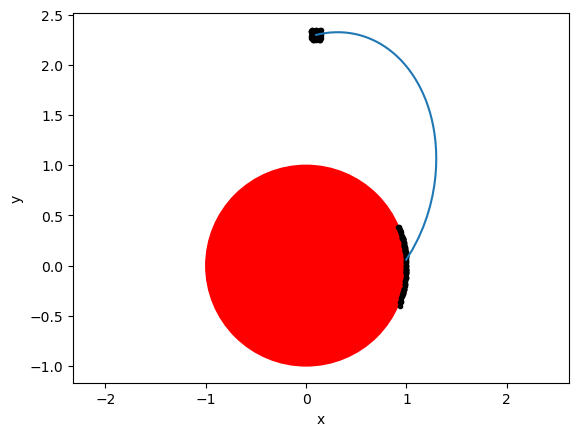

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(out[:, 0], out[:, 1])

circle = plt.Circle((0, 0), 1, color="r")
ax.add_patch(circle)
plt.axis("equal")

plt.scatter(out[0, 0] + dx0, out[0, 1] + dy0, marker=".", color="k")
plt.scatter(out[-1, 0] + dx, out[-1, 1] + dy, marker=".", color="k")

plt.xlabel("x")
plt.ylabel("y");

Eureka!!! The polynomial map built is able to predict accurately the state of the dynamical system at the event trigger condition .... without actually performing the nonlinear numerical integration.

That's all folks!